reading 'data.json'...
verifying user parameters...
  minWave: 1900
  maxWave: 2300
  molecule: CO
  pressure: 0.01
  resolution: 1
  numScan: 1
  zeroFill: 0
  source: 3100
  beamsplitter: AR_ZnSe
  cellWindow: CaF2
  detector: MCT
calculating wstep...
performing 'calc_spectrum'...
plotting result of 'calc_spectrum'...
performing 'get_wavelength'...
performing 'Spectrum()' for sPlanck...


/home/vanfossen/test/function-rework/venv/lib/python3.10/site-packages/radis/spectrum/spectrum.py:4400: UserWarning: Wavespace is not evenly spaced (0.028%) for transmittance_noslit. This may create problems if later convolving with slit function (`s.apply_slit()`). You can use `s.resample_even()`
  warn(


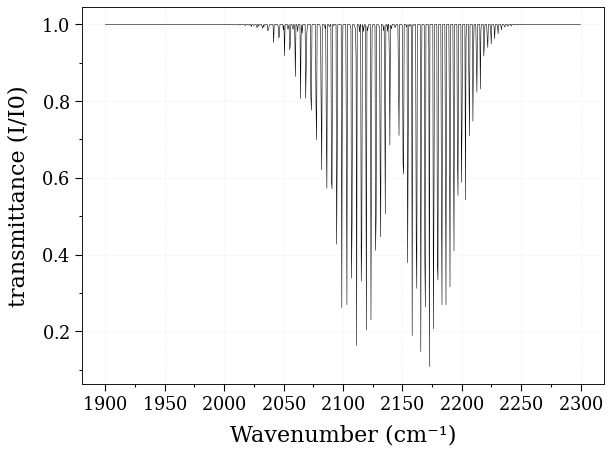

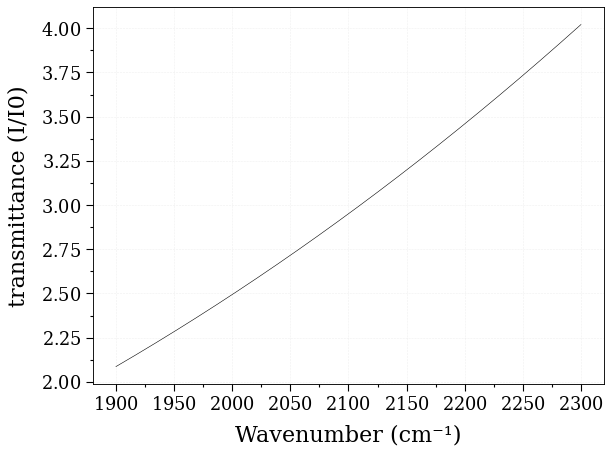

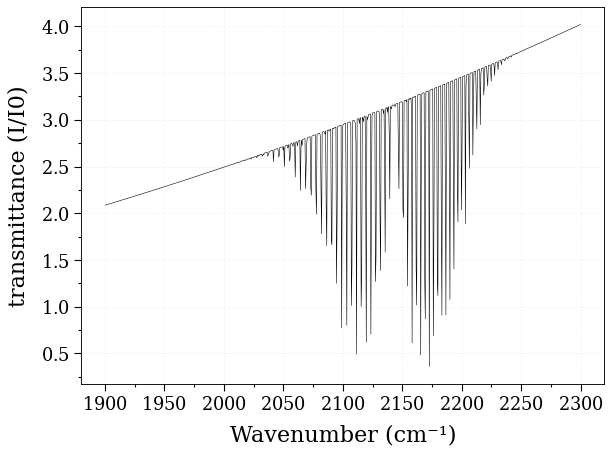

In [2]:
import json

import numpy as np
from radis import SerialSlabs, Spectrum, calc_spectrum

from blackbody_window_detector import __sPlanck
from helper import __calc_wstep, __param_check

DEBUG = True


def __log(string):
    if DEBUG:
        print(string)


def main():
    # read local data file into a dictionary
    __log("reading 'data.json'...")
    with open("./data.json", "r") as data_json:
        data = json.load(data_json)

    # verify user input is valid
    __log("verifying user parameters...")
    if not __param_check(data):
        print("parameter check failed")
        return

    # resolution of wavenumber grid (cm^-1)
    #   https://radis.readthedocs.io/en/latest/source/radis.lbl.calc.html#radis.lbl.calc.calc_spectrum:~:text=wstep%20(float%20(,%27auto%27)
    __log("calculating wstep...")
    wstep = __calc_wstep(data["resolution"], data["zeroFill"])

    try:
        # ----- a.) transmission spectrum of gas sample -----
        #   https://radis.readthedocs.io/en/latest/source/radis.lbl.calc.html#radis.lbl.calc.calc_spectrum
        __log("performing 'calc_spectrum'...")
        s = calc_spectrum(
            data["minWave"],
            data["maxWave"],
            molecule=data["molecule"],
            isotope="1,2,3",
            pressure=data["pressure"],
            Tgas=294.15,
            path_length=10,
            wstep=wstep,
            databank="hitran",
            verbose=False,
            warnings={"AccuracyError": "ignore"},
        )

        # s.resample_even()
        # s.resample_even()
        # s.resample_even()
        # s.resample_even()
        # s.resample_even()
        # s.resample_even()
        # s.resample_even()

        __log("plotting result of 'calc_spectrum'...")
        s.plot("transmittance_noslit", wunit="cm")

    except Exception as e:
        print(f"ERROR: {e}")
        return False

    # ----- Pre-processing -----
    # Generate the necessary spectra for each component of the following processing steps. The spectra are generated based on the function provided in the call to the Spectrum constructor

    # return wavelength in defined medium.
    #   https://radis.readthedocs.io/en/latest/source/radis.spectrum.spectrum.html#radis.spectrum.spectrum.Spectrum.get_wavelength
    __log("performing 'get_wavelength'...")
    w = s.get_wavelength()

    __log("performing 'Spectrum()' for sPlanck...")
    spec_sPlanck = Spectrum(
        {
            "wavelength": w,
            "transmittance_noslit": __sPlanck(w, data["source"]),
            "radiance_noslit": np.zeros_like(w),
        },
        wunit="nm",
        units={"radiance_noslit": "mW/cm2/sr/nm", "transmittance_noslit": ""},
        name="sPlanck",
    )
    spec_sPlanck.plot("transmittance_noslit", wunit="cm")

    # ----- b.) blackbody spectrum of source -----
    # SerialSlabs() multiplies the transmittance values (y-values) of the provided spectrum, s, with the corresponding transmittance values of the spec_sPlanck spectrum
    #   https://radis.readthedocs.io/en/latest/source/radis.los.slabs.html#radis.los.slabs.SerialSlabs
    spectrum = SerialSlabs(s, spec_sPlanck)
    spectrum.plot("transmittance_noslit", wunit="cm")


if __name__ == "__main__":
    main()